# Import 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
import re
import random
import pickle
from glob import glob

# Premiers essais sur les données

In [122]:
# Allure des données générales sur les stations
info = pd.read_json('data/download/stations_info.json')
data_info = pd.DataFrame(info.data.stations)
print('Nombre de stations :', len(data_info))
data_info.head()

Nombre de stations : 1454


,station_id,name,lat,lon,capacity,stationCode,rental_methods
0,213688169,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,16107,NaN
1,653222953,Mairie de Rosny-sous-Bois,48.871257,2.486581,30,31104,[CREDITCARD]
2,36255,Toudouze - Clauzel,48.879296,2.337360,21,9020,[CREDITCARD]
3,37815204,Mairie du 12ème,48.840855,2.387555,30,12109,NaN
4,17278902806,Rouget de L'isle - Watteau,48.778193,2.396302,0,44015,NaN


In [123]:
mini = data_info.groupby('stationCode').station_id.count().min()
maxi = data_info.groupby('stationCode').station_id.count().max()
print(mini, maxi)

mini = data_info.groupby('station_id').stationCode.count().min()
maxi = data_info.groupby('station_id').stationCode.count().max()
print(mini, maxi)

# Il y a exactement un station_id par stationCode, et inversement, donc on peut en garder un seul


1 1
1 1


In [124]:
# Allure des données sur les vélos à un temps donné : 
data0 = pd.read_json('data/download/stations_status_2023_03_17_16_59_24.json')
data = pd.DataFrame(data0.data.stations)
data.head()

,stationCode,station_id,num_bikes_available,numBikesAvailable,num_bikes_available_types,num_docks_available,numDocksAvailable,is_installed,is_returning,is_renting,last_reported
0,16107,213688169,7,7,"[{'mechanical': 4}, {'ebike': 3}]",28,28,1,1,1,1679066917
1,31104,653222953,8,8,"[{'mechanical': 6}, {'ebike': 2}]",20,20,1,1,1,1679066353
2,9020,36255,2,2,"[{'mechanical': 0}, {'ebike': 2}]",19,19,1,1,1,1679066838
3,12109,37815204,18,18,"[{'mechanical': 16}, {'ebike': 2}]",12,12,1,1,1,1679066819
4,44015,17278902806,0,0,"[{'mechanical': 0}, {'ebike': 0}]",0,0,0,0,0,1675935337


In [125]:
#On vérifie que certaines colonnes sont bien des doublons : 
print( (data.num_bikes_available != data.numBikesAvailable).any() , 
       (data.num_docks_available != data.numDocksAvailable).any() )

False False


In [126]:
# On va garder la version avec des undersocres plutot que des majuscules, vu que les autres champs sont pareils :
data = data.drop(['numBikesAvailable','numDocksAvailable','stationCode'] , axis=1)

In [127]:
data.head()

,station_id,num_bikes_available,num_bikes_available_types,num_docks_available,is_installed,is_returning,is_renting,last_reported
0,213688169,7,"[{'mechanical': 4}, {'ebike': 3}]",28,1,1,1,1679066917
1,653222953,8,"[{'mechanical': 6}, {'ebike': 2}]",20,1,1,1,1679066353
2,36255,2,"[{'mechanical': 0}, {'ebike': 2}]",19,1,1,1,1679066838
3,37815204,18,"[{'mechanical': 16}, {'ebike': 2}]",12,1,1,1,1679066819
4,17278902806,0,"[{'mechanical': 0}, {'ebike': 0}]",0,0,0,0,1675935337


# Génération du dataframe

Pour ajouter les données à chaque temps, on va garder la structure des fichiers à un temps donné pour la table totale, mais rajouter un champ 'time' au format datetime. 

Chaque station sera donc présente une fois par temps de mesure, et on pourra extraire ce temps à partir du stationCode ou station_id.

In [128]:
t_ini = time.time()
df1 = pd.read_csv("data/datasets/stations_status_2023_03_20.zip")
df0 = pd.read_csv("data/datasets/stations_status_2023_03_19.zip")
t_fin = time.time()
print(f'The dataframes of {df0.size} and {df1.size} elements were built in {t_fin-t_ini} seconds.')

The dataframes of 13571636 and 13514930 elements were built in 2.864990711212158 seconds.


In [129]:
data_info.dtypes

station_id          int64
name               object
lat               float64
lon               float64
capacity            int64
stationCode        object
rental_methods     object
dtype: object

In [130]:
df1.dtypes

Unnamed: 0                    int64
station_id                    int64
num_bikes_available           int64
num_bikes_available_mech    float64
num_bikes_available_elec    float64
num_docks_available           int64
is_installed                  int64
is_returning                  int64
is_renting                    int64
last_reported                 int64
time                         object
weekday                       int64
hour                         object
dtype: object

In [131]:
df1['time'] = pd.to_datetime(df1['time'])

In [132]:
df1.drop(['Unnamed: 0'] , axis=1)


,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,weekday,hour
0,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:00:18,0,00:00:18
1,653222953,18,3.0,15.0,10,1,1,1,1679264870,2023-03-20 00:00:18,0,00:00:18
2,36255,7,2.0,5.0,14,1,1,1,1679264895,2023-03-20 00:00:18,0,00:00:18
3,37815204,28,18.0,10.0,1,1,1,1,1679265052,2023-03-20 00:00:18,0,00:00:18
4,17278902806,0,0.0,0.0,0,0,0,0,1675935337,2023-03-20 00:00:18,0,00:00:18
...,...,...,...,...,...,...,...,...,...,...,...,...
1039605,54000604,17,1.0,16.0,17,1,1,1,1679351237,2023-03-20 23:58:01,0,23:58:01
1039606,43247738,25,11.0,14.0,4,1,1,1,1679351585,2023-03-20 23:58:01,0,23:58:01
1039607,102311820,13,10.0,3.0,21,1,1,1,1679351510,2023-03-20 23:58:01,0,23:58:01
1039608,368766689,36,26.0,10.0,3,1,1,1,1679351599,2023-03-20 23:58:01,0,23:58:01


# Analyse des résultats

## Allure générale

In [133]:
print(f'Dataframe avec {df1.size} lignes')
df1.describe(include='all')

Dataframe avec 13514930 lignes


C:\Users\julie\AppData\Local\Temp\ipykernel_19412\1496766962.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df1.describe(include='all')


,Unnamed: 0,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,weekday,hour
count,1.039610e+06,1.039610e+06,1.039610e+06,1.035248e+06,1.035248e+06,1.039610e+06,1.039610e+06,1.039610e+06,1.039610e+06,1.039610e+06,1039610,1039610.0,1039610
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,715,NaN,715
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-20 00:00:18,NaN,00:00:18
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1454,NaN,1454
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-20 00:00:18,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-20 23:58:01,NaN,NaN
mean,7.265000e+02,1.118766e+09,1.121047e+01,7.052977e+00,4.153779e+00,1.879558e+01,9.889959e-01,9.750560e-01,9.750560e-01,1.678586e+09,NaN,0.0,NaN
std,4.197337e+02,3.235795e+09,1.084259e+01,9.028498e+00,4.432792e+00,1.254143e+01,1.043218e-01,1.559545e-01,1.559545e-01,8.701070e+06,NaN,0.0,NaN
min,0.000000e+00,6.245000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.520582e+09,NaN,0.0,NaN
25%,3.630000e+02,5.592789e+07,3.000000e+00,1.000000e+00,1.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.679283e+09,NaN,0.0,NaN


In [134]:
df1[df1['station_id'] == 36255]

,Unnamed: 0,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,weekday,hour
2,2,36255,7,2.0,5.0,14,1,1,1,1679264895,2023-03-20 00:00:18,0,00:00:18
1456,2,36255,7,2.0,5.0,14,1,1,1,1679264895,2023-03-20 00:02:17,0,00:02:17
2910,2,36255,7,2.0,5.0,14,1,1,1,1679264895,2023-03-20 00:04:18,0,00:04:18
4364,2,36255,6,1.0,5.0,15,1,1,1,1679264895,2023-03-20 00:06:17,0,00:06:17
5818,2,36255,6,1.0,5.0,15,1,1,1,1679264895,2023-03-20 00:08:18,0,00:08:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032342,2,36255,5,2.0,3.0,16,1,1,1,1679351582,2023-03-20 23:49:01,0,23:49:01
1033796,2,36255,5,2.0,3.0,16,1,1,1,1679351582,2023-03-20 23:52:01,0,23:52:01
1035250,2,36255,5,2.0,3.0,16,1,1,1,1679351582,2023-03-20 23:54:01,0,23:54:01
1036704,2,36255,5,2.0,3.0,16,1,1,1,1679351582,2023-03-20 23:56:01,0,23:56:01


In [135]:
type(df1.iloc[451251, -1])

str

## Variation au cours du temps

In [147]:
df = df1.merge(data_info, on = "station_id").drop(["Unnamed: 0", "rental_methods", "stationCode"] , axis=1)
df["occupation_prct"] = 100 * df["num_bikes_available"] / df["capacity"]
df

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,weekday,hour,name,lat,lon,capacity,occupation_prct
0,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:00:18,0,00:00:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857
1,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:02:17,0,00:02:17,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857
2,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:04:18,0,00:04:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857
3,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:06:17,0,00:06:17,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857
4,213688169,5,2.0,3.0,30,1,1,1,1679264946,2023-03-20 00:08:18,0,00:08:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,14.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039605,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:49:01,0,23:49:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537
1039606,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:52:01,0,23:52:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537
1039607,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:54:01,0,23:54:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537
1039608,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:56:01,0,23:56:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537


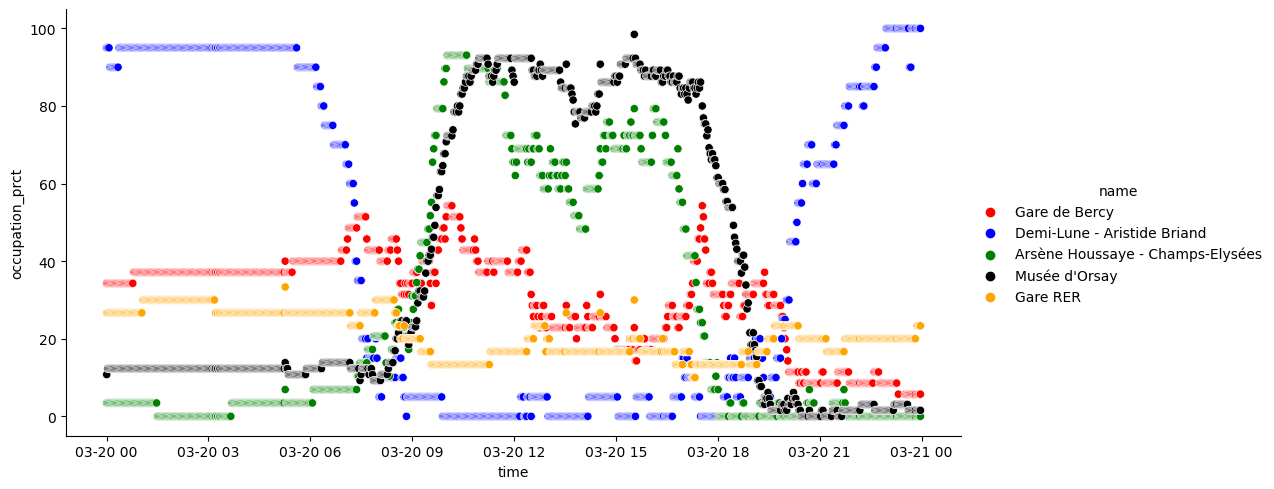

In [148]:
station_red = [1109534105, 13373801574, 82421994, 100863462, 128932790]
df_red = df[df['station_id'].isin(station_red)]
sns.relplot(data=df_red, x='time', y='occupation_prct', hue='name', height=5, aspect=2, 
            palette=['red','blue','green', 'black', 'orange'])

plt.show()

In [151]:
df[df["occupation_prct"] > 100]["name"].value_counts()

Westermeyer - Paul Vaillant-Couturier       566
Enfants du Paradis - Peupliers              552
Place Balard                                495
Carrefour Pleyel                            305
Saint-Denis - Rivoli                        284
Sebastopol - Rambuteau                      278
Madeleine Vionnet                           272
Malesherbes - Place de la Madeleine         260
Place du Moulin de Javel                    250
Caumartin - Provence                        197
Daumesnil - Picpus                          194
BNF - Bibliothèque Nationale de France      187
Bercy - Villot                              128
Mornay - Sully                              115
Quai des Célestins - Henri IV                70
Saint-Antoine Sévigné                        56
Gare Saint-Lazare - Cour du Havre            43
Abbé Groult - Convention                     38
Place Charles Vallin                         30
Aristide Briand - Place de la Résistance      8
Name: name, dtype: int64

In [153]:
df[(df["occupation_prct"] < 5) & (df["is_returning"] == 1)]["name"].value_counts()

Jean Bleuzen - Square du 11 Novembre    542
Alexander Fleming - Belvédère           530
Douai - Pierre Fontaine                 510
Belleville - Pyrénées                   509
Moulin de la Pointe                     494
                                       ... 
Murat - Porte de Saint-Cloud              1
Silly - Louis Blériot                     1
Neuilly - Petit                           1
Marcadet - Barbès                         1
Cordelières - Arago                       1
Name: name, Length: 848, dtype: int64

In [95]:
df

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,weekday,hour,name,lat,lon,capacity,occupation_prct
0,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:00:18,0,00:00:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857
1,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:02:17,0,00:02:17,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857
2,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:04:18,0,00:04:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857
3,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:06:17,0,00:06:17,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857
4,213688169,5,2.0,3.0,30,1,1,1,1679264946,2023-03-20 00:08:18,0,00:08:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,14.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039605,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:49:01,0,23:49:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537
1039606,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:52:01,0,23:52:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537
1039607,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:54:01,0,23:54:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537
1039608,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:56:01,0,23:56:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537


In [154]:
LIMITS = [5,50,95]

df[df["occupation_prct"] < 5]

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,weekday,hour,name,lat,lon,capacity,occupation_prct
528,213688169,1,1.0,0.0,33,1,1,1,1679329947,2023-03-20 17:40:36,0,17:40:36,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,2.857143
529,213688169,1,1.0,0.0,33,1,1,1,1679329947,2023-03-20 17:42:36,0,17:42:36,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,2.857143
530,213688169,1,1.0,0.0,33,1,1,1,1679329947,2023-03-20 17:44:36,0,17:44:36,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,2.857143
531,213688169,1,1.0,0.0,33,1,1,1,1679329947,2023-03-20 17:46:36,0,17:46:36,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,2.857143
532,213688169,1,1.0,0.0,33,1,1,1,1679329947,2023-03-20 17:48:36,0,17:48:36,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,2.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039605,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:49:01,0,23:49:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537
1039606,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:52:01,0,23:52:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537
1039607,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:54:01,0,23:54:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537
1039608,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:56:01,0,23:56:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537


In [120]:
dftest

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,weekday,hour,name,lat,lon,capacity,occupation_prct
528,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0.0
529,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0.0
530,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0.0
531,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0.0
532,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039605,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0.0
1039606,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0.0
1039607,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0.0
1039608,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0.0
